In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from mod_my_utils.read_write_data import *

In [4]:
class Sto_osc:
    def __init__(self, folder_path='data/',stock_name='AMD',index_col ='Date',period =300, buy_threshold=20,sell_threshold=80):
        self.period=period
        self.buy_threshold=buy_threshold
        self.sell_threshold= sell_threshold
        self.folder_path = folder_path
        self.stock_name = stock_name
        self.index_col = index_col
        
    def read_data(self):
        stock_data = get_price_csv(folder_name = self.folder_path, symbol = self.stock_name, index_col = self.index_col)
        data = stock_data[['Adj. Close']].copy()
        data.columns= ['price']
        data['Adj. High']=stock_data['Adj. High']
        data['Adj. Low']= stock_data['Adj. Low']
        data.tail(20)
        
        return data
    
    def sto_osc(self, data):
        data['highest_high'] = data['Adj. High'].rolling(window=self.period).max()
        data['lowest_low' ] = data['Adj. Low'].rolling(window=self.period).min()
        data['Stochastic Oscillator'] = 100*(data['price']- data['lowest_low'])/(data['highest_high']- data['lowest_low']) 
        data['%d'] = data['Stochastic Oscillator'].rolling(window=self.period).mean() 
        data[['Stochastic Oscillator', '%d']].plot()
        
        return data
    
    def parameter(self, data):
        par = pd.DataFrame(index= data.index) 
        par['price'] = data['price']
        par['%K']=  data['Stochastic Oscillator']
        par['%d'] = data['%d']
        
        return par
    
    def buysell_signal(self,data):
        signals = pd.DataFrame(index= data.index) 
        signals['price'] = data['price']
        signals['%K']=  data['%K']
        signals['%d'] = data['%d']
        signals['b']=0.0
        signals['buy']=0
        signals['sell']=0
        signals['s']=0.0
        signals['b']=np.where(data['%K']< self.buy_threshold, -1.0,0.0)
        signals['s']=np.where(data['%K']> self.sell_threshold, 1.0,0.0)
        signals['buy'] = signals['b'].diff()
        signals['sell'] = signals['s'].diff()
        signals.loc[signals['buy']==-1.0,['buy']] = 0      # Replacing false buy signal with 0 
        signals.loc[signals['sell']== 1.0,['sell']] = 0    # Replacing false sell signal with 0
        signals['buy_sell'] = signals['buy'] + signals['sell']
        
        return signals
    
    def KD_signal(self,buysellsignal):
        KD = pd.DataFrame(index= buysellsignal.index) 
        KD['price'] = buysellsignal['price']
        KD['K']=  buysellsignal['%K']
        KD['d'] = buysellsignal['%d']
        KD['b']=0.0
        KD['s']=0.0
        KD['b']=np.where(buysellsignal['%K']<buysellsignal['%d'], -1.0,0.0)
        KD['s']=np.where(buysellsignal['%K']>buysellsignal['%d'], 1.0,0.0)
        KD['buy'] = buysellsignal['b'].diff()
        KD['sell'] = buysellsignal['s'].diff()
        KD.loc[KD['buy']==-1.0,['buy']] = 0 
        KD.loc[KD['sell']== 1.0,['sell']] = 0 
        KD['buy_sell'] = KD['buy'] + KD['sell']
        #signals.head(50)
        KD['buy_sell'].plot()

        return KD
    
    def plot_signal(self,get_signal):
        
        graph = plt.figure(figsize=(20,12))
        ax1 = graph.add_subplot(211, ylabel= '%K')
        ax2 = graph.add_subplot(212,ylabel= 'price')

        get_signal['K'].plot(ax=ax1,title = 'Signals on K')

        ax1.axhline(y= self.buy_threshold, color = "m", lw = 2)
        ax1.axhline(y= self.sell_threshold, color = "g", lw = 2)
        ax1.plot(get_signal.loc[get_signal.buy_sell == 1].index, get_signal.K[get_signal.buy_sell == 1],"^", markersize = 12, color ='r')
        ax1.plot(get_signal.loc[get_signal.buy_sell == -1].index, get_signal.K[get_signal.buy_sell == -1],"v", markersize = 12, color ='b')

        get_signal['price'].plot(ax=ax2,title = 'Signals on price')

        ax2.plot(get_signal.loc[get_signal.buy_sell == 1].index, get_signal.loc[get_signal.buy_sell == 1].price,"^", markersize = 12, color ='r')
        ax2.plot(get_signal.loc[get_signal.buy_sell == -1].index, get_signal.loc[get_signal.buy_sell == -1].price,"v", markersize = 12, color ='b')


        plt.show()

        

stock name:  AMD


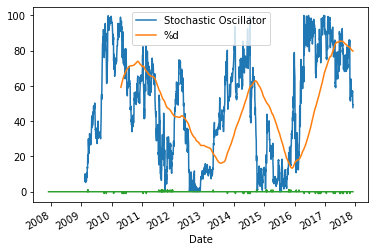

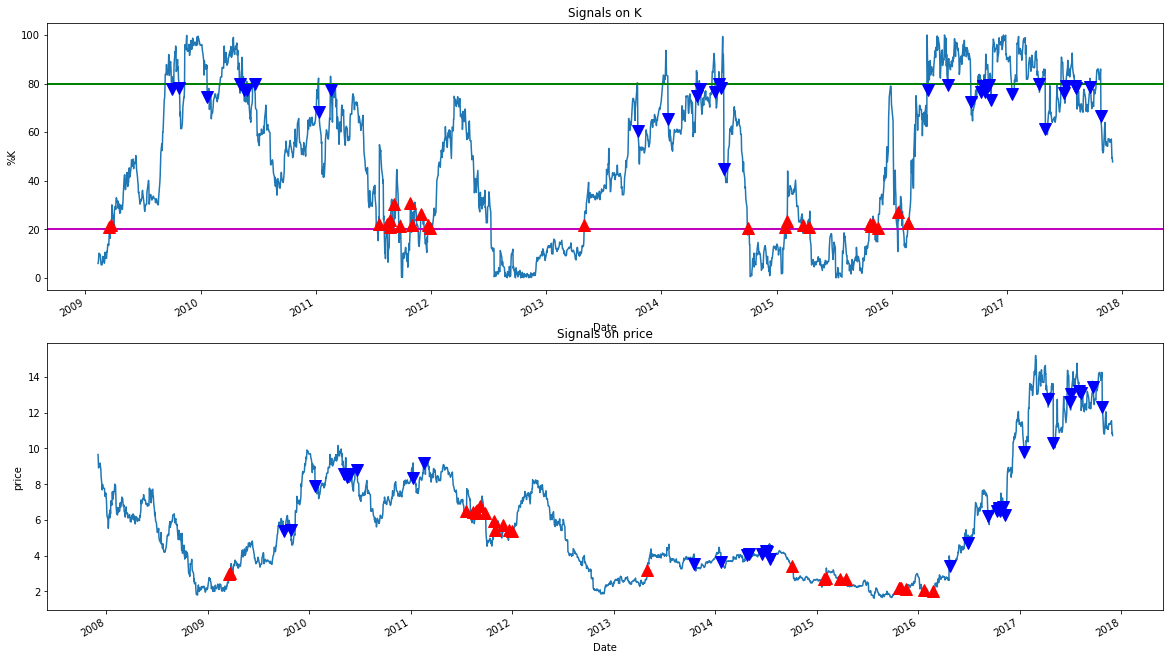

In [6]:
stochastic=Sto_osc()
data=stochastic.read_data()
dta= stochastic.sto_osc(data)

p= stochastic.parameter(dta)

dt= stochastic.buysell_signal(p)
d= stochastic.KD_signal(dt)
stochastic.plot_signal(d)